# Validation framework
 
To be able to improve and validate our model, we need to be able to assess it's performance. Specifically we must be able to automatically judge whether a detected logo is a *true positive* or *false positive*. In our case, this means establishing whether or not each detected logo corresponds to an equivalent bounding-box in the BelgaLogos annotations.

To do this, I use a very simple algorithm:
1. Use the model to detect a list of logos in the image, with each labeled by it's detected logo name (e.g "Kia", "Peugeot").
2. The keypoint-matching returns a polygon that bounds the logo. For simplicity, convert this to an [axis-aligned bounding box](https://en.wikipedia.org/wiki/Bounding_volume) (AABB) of the detected logo. This makes the bounding-box a regular rectangle.
3. Loop through all BelgaLogos annotations that match the name of the detected logo. For each, compute the overlap area of the truth, and detected bounding-boxes.
4. If at least 20% of the AABB overlaps a BelgaLogo 'true' bounding-box of the same name, then declare a **true positive**. Otherwise decleare a **false positive**.

Where the 20% criterion has been tuned a little bit for reasonable results. The above algorithm has been implemented in `model_validation.py`. Let's see how effective this is on a few images from the KIA dataset. 

In [1]:
import lib.model as model
import cv2, os

# Initialise model
SIFT = cv2.xfeatures2d.SIFT_create()
SIFTMatcher = model.KeypointMatcher(SIFT, cv2.NORM_L2SQR)

# Train on KIA logo
logo_name = "Kia"
logo_filename = os.path.join("data", "logos", logo_name.lower() + '.jpg')
logo_image = cv2.imread(logo_filename)
SIFTMatcher.add_template(logo_name, logo_image)

We read in the dataset metadata and pick 9 random KIA images:

In [2]:
from lib.validation import validate_detected_objects
import lib.load_data as ld
import random

# Read in the BelgaLogos dataset
metadata = ld.read_metadata()
metadata = ld.filter_by_boundingbox(metadata, 10, 800)
kia_metadata = metadata[(metadata.brand == logo_name) & (metadata.ok == True)]

# Get the list of all unique image filenames in the Kia dataset
images = kia_metadata["image_file"].unique()

# Get a sample of 9 random images
random.seed(1)
images = random.sample(list(images), 9)

Then run over each of these images, generating an annotated version
with the bounding boxes either green (for true positive) or red (false positive).

In [3]:
annotated_image_list = []
for image in images:
    # Fetch corresponding metadata for this image
    image_metadata = kia_metadata[kia_metadata["image_file"] == image]
    # Read the image file
    test_image = cv2.imread(os.path.join("data", "images", image))
    
    # Run the model over the image and validate the results with the above algorithm
    detected_objects = SIFTMatcher.detect_objects(test_image)
    correct_match = validate_detected_objects(image_metadata, detected_objects)
    
    # Draw the images with a green box where there is a match, or a red box otherwise
    annotated_image = model.annotate_image_with_objects(test_image, detected_objects, correct_match = correct_match)
    annotated_image_list.append(annotated_image)

and finally plot the images

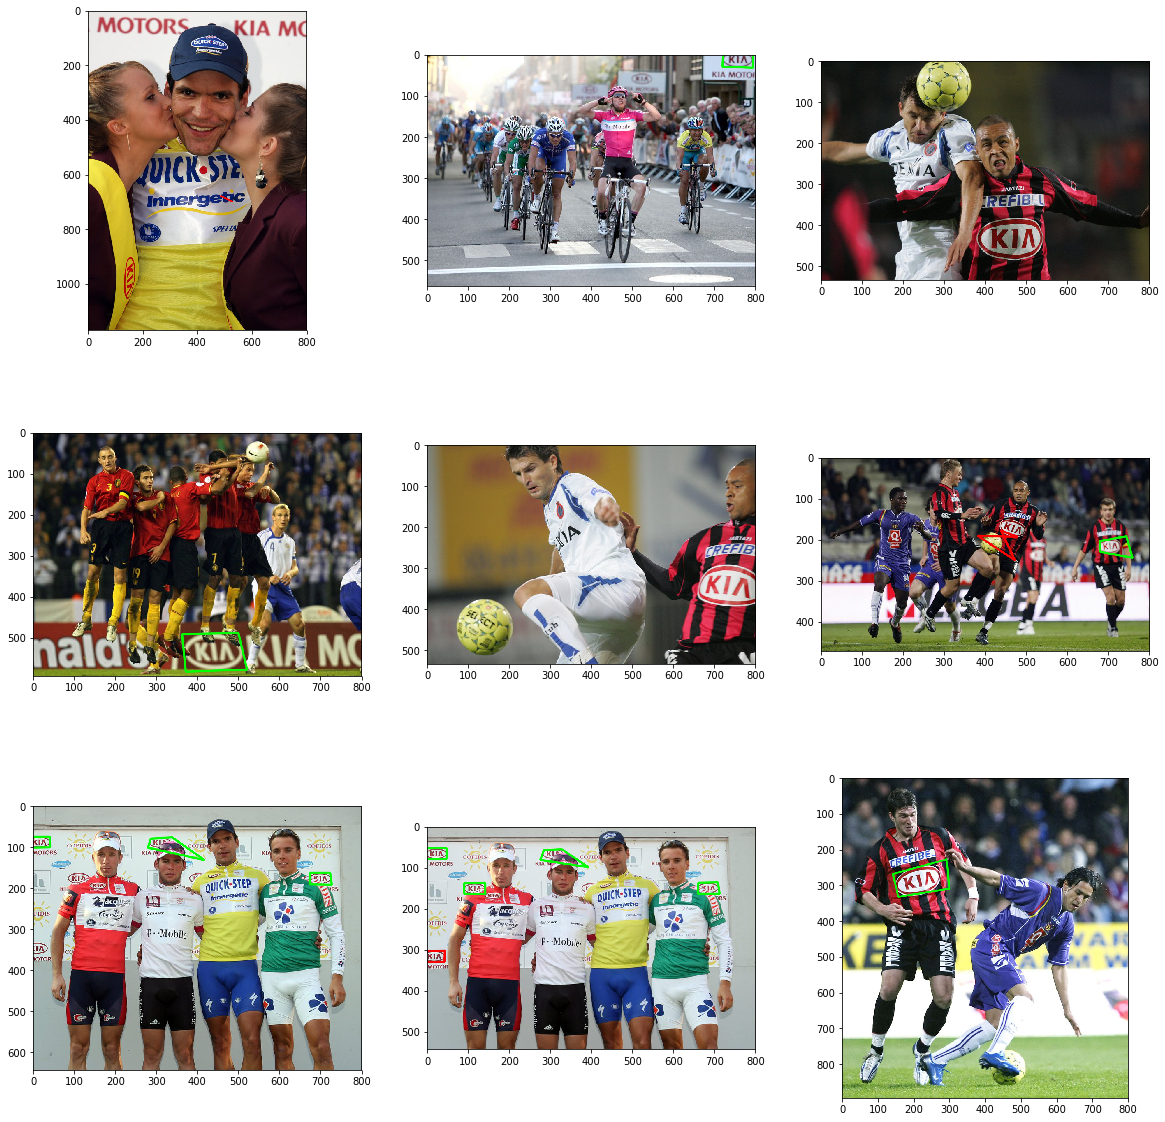

In [4]:
from matplotlib import pyplot as plt
import numpy as np
fig, ax = plt.subplots(3, 3, figsize=(20,20))
axes = np.ndarray.flatten(ax)
for i, ax in enumerate(axes):
    ax.imshow(cv2.cvtColor(annotated_image_list[i], cv2.COLOR_BGR2RGB))
plt.show()

Here our basic validation algorithm appears to be (mostly) working. False positives visible in the top left and centre-right images,
true positives visible in several images. The algorithm is not perfect though, with the lower-centre image showing a false-positive that should be true.

This true/false positive categorisation algorithm could be improved, principally by computing the overlap between the actual bounding polygon and the annotations (rather than using the AABB). But for now it provides a useful, rough heuristic for model quality.

## Quantitative validation
Let's quanitify the agreement a bit better by wrapping the above loop-over-images into a function that counts true and false positives. This is done in `model_validation.py`. We shall try it out on the full KIA dataset

In [5]:
%%time
from lib.validation import study_matches
print(study_matches(kia_metadata, SIFTMatcher))

true_positives                80.000000
actual_positives             136.000000
true_positive_ratio            0.588235
false_positives               15.000000
false_positives_per_image      0.227273
image_count                   66.000000
dtype: float64
CPU times: user 2min 8s, sys: 7.01 s, total: 2min 15s
Wall time: 1min 52s
